In [1]:
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.image as mpimg
import numpy as np
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import tensorflow.metrics
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil, random
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

### Define preprocessing function for demographic data

### Notice: age was rounded in steps of 5

In [2]:
def preprocess_dem(train,test):


    #replace missing age values by median
    train['age'] = train['age'].fillna(train['age'].median())
    test['age'] = test['age'].fillna(train['age'].median())
    
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    train["age"] = cs.fit_transform(train["age"].values.reshape(-1,1))
    test["age"] = cs.transform(test["age"].values.reshape(-1,1))
 
    train['sex'].replace("unknown",train['sex'].value_counts().index[0], inplace=True)
    train["sex"] = np.where(train['sex']=="female",1,0)
    
    test['sex'].replace("unknown",train['sex'].value_counts().index[0], inplace=True)
    test["sex"] = np.where(test['sex']=="female",1,0)
    
    # return the concatenated training and testing data
    return (train, test)

### Load demographic data for all images (inkl. augmented images)

In [3]:
diagnose = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

train_dir = "/Users/leona/PythonWork/Github_Projects/Final_Pro/data/ISIC2018_Task3_Training_Input/train/"
validation_dir = "/Users/leona/PythonWork/Github_Projects/Final_Pro/data/ISIC2018_Task3_Training_Input/validation/"

### Load main, train and test dataframe

In [4]:
meta = pd.read_pickle("./meta.pkl")

In [5]:
train = pd.read_pickle("./aug_train.pkl")

In [6]:
validation = pd.read_pickle("./aug_test.pkl")

In [7]:
train_pr, validation_pr = preprocess_dem(train,validation)

### Define custom image generator

In [8]:
lb = LabelBinarizer()
lb.fit(train_pr.dx)

def get_input(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    return(img_array)

def preprocess_input(img):
    """ Same preprocessing function as mobilenets preprocess input"""
    img /= 255.
    img -= 0.5
    img *= 2.
    return img

def multi_input_generator(df, batch_size, source_dir,shuffle=True):
    """Read images and metadata from dataframe. 
    Arguments: 
    - source_dir = either train or validation diectory
    -> important: for test batches set shuffle=False and batch_size=1"""
    
    idx = 0

    while True:
        if shuffle:
            batch = df.sample(n=batch_size, replace=False)
        else:
            batch = df.loc[idx:(idx*batch_size), :] #attention:works only with batch_size=1

        batch_input1 = []
        batch_input2 = []
        batch_output = [] 
          
        # Read in each input, perform preprocessing and get labels
        for i in batch.index:
            
            full_path = source_dir + str(batch.loc[i].dx) + "/" + str(batch.loc[i].aug_id)
            input1 = get_input(full_path)
            input2 = [batch.loc[i].age, batch.loc[i].sex]
            output = batch.loc[i].dx
            
            input_pre = preprocess_input(input1)
            batch_input1 += [ input_pre ]
            batch_input2 += [ input2 ]
            batch_output += [ output ]
        
        # flatten the image list so that it looks like the tensorflow iterator
        batch_input1 = [val for sublist in batch_input1 for val in sublist]
        
        # Return a tuple of ([input,input],output) to feed the network
        batch_x1 = np.array(batch_input1)
        batch_x2 = np.array(batch_input2, dtype="float32")
        batch_y = lb.transform(np.array(batch_output)).astype("float32")
        
        yield[batch_x1, batch_x2], batch_y
        idx += 1

In [9]:
train_batches = multi_input_generator(train_pr,10,train_dir)

In [10]:
valid_batches = multi_input_generator(validation_pr,10,validation_dir)

In [11]:
test_batches = multi_input_generator(validation_pr,1, validation_dir,shuffle=False)

## Combine models

### Setup model input

In [12]:
num_train_samples = 8912 # length of original not-augmented train data
num_val_samples = 1103
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [13]:
cnn = tensorflow.keras.models.load_model('model.h5', compile=False)

W0819 12:34:18.302448 4671083968 deprecation.py:506] From /Users/leona/anaconda3/envs/finalpro/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 12:34:18.303957 4671083968 deprecation.py:506] From /Users/leona/anaconda3/envs/finalpro/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 12:34:18.305925 4671083968 deprecation.py:506] From /Users/leona/anaconda3/envs/finalpro/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling

In [14]:
cnn_output = cnn.layers[-3].output # global average pooling layer

In [15]:
input_dem = tensorflow.keras.layers.Input(shape=(2,), name="input_dem")
x_dem = Dense(16, activation="relu",name="dense_dem")(input_dem)
x_dem = Dropout(0.25, name="dropout_dem")(x_dem)

In [16]:
merge_layer = layers.concatenate(inputs=[cnn_output,x_dem])

In [17]:
x = Dense(64, activation="relu")(merge_layer)
x = Dropout(0.25)(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(7, activation='softmax')(x)

In [18]:
combined_model_new = Model(inputs=[cnn.input, input_dem], outputs=predictions)

### Compile merged model

In [19]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 15 layers in the new model.
# The last 15 layers of the model will be trained.

for layer in combined_model_new.layers[:-10]:
    layer.trainable = False

In [20]:
# Define Top3 Accuracy
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [21]:
combined_model_new.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_3_accuracy])

#### Plot the model architecture

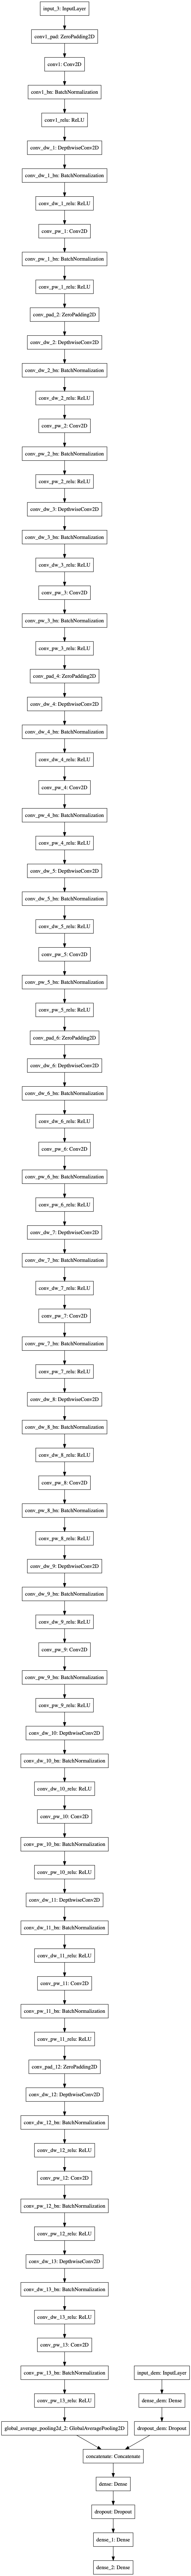

In [27]:
tensorflow.keras.utils.plot_model(combined_model_new, to_file='model_combined.png')

#### Define class weights to account for class imbalance

In [ ]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
filepath = "combined_model_new.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

combined_new_history = combined_model_new.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

In [ ]:
cnn.load_weights('combined_model_new.h5')

val_loss, val_cat_acc, val_top_3_acc = \
cnn.evaluate_generator(test_batches, 
                        steps= len(validation_pr))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_3_acc:', val_top_3_acc)

### Get predictions, ytrue and ypred

In [ ]:
predictions = cnn.predict_generator(test_batches, steps=len(validation_pr), verbose=1)

In [ ]:
cnn.predict()

In [ ]:
ytrue = pd.Categorical(validation_pr.dx).codes
ytrue

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_pred

In [ ]:
plot_labels = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(ytrue, y_pred, target_names=plot_labels)

print(report)

### Print confusion matrix

In [ ]:
confusion_matrix(ytrue, predictions.argmax(axis=1))

### Display loss and accuracy curves

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette= "Set2", style= 'darkgrid')
sns.set_context("notebook",font_scale=1.5, rc={"lines.linewidth": 2.5})

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure(figsize=(15,5))

plt.plot(epochs, acc, label='Training cat acc')
plt.plot(epochs, val_acc, label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure(figsize=(15,5))


plt.plot(epochs, train_top3_acc, label='Training top3 acc')
plt.plot(epochs, val_top3_acc, label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()